# Dask start

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:44077")

# Import

In [2]:
import sys
sys.path.insert(1, '..')

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import gsw
import gcm_filters
from dask import compute
import xgcm
import xesmf as xe
import os

In [4]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
#%matplotlib widget
%matplotlib inline

# Load data

Choose cases

In [6]:
data=[dict() for i in range(6)]

In [7]:
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR wint'})
data[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR sum'})
data[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'MIDATL wint'})
data[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'MIDATL sum'})
data[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED wint'})
data[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED sum'})

In [8]:
from validate_catalog import all_params
params_dict, cat = all_params()

In [9]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,1),y=y_slice,x=x_slice) 
coord_slice = dict(y=y_slice,x=x_slice)

In [10]:
chunk_dict = {'x' : -1, 'y' : -1, 'time_counter' : 150}

In [11]:
%%time
for i in range(len(data)) :
    current_set = cat.eNATL60(region=data[i]['region'],datatype='surface_hourly', season=data[i]['season']).to_dask()
    #current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
    current_set = current_set.isel(data_slice)
    current_set = current_set.chunk(chunk_dict)
    data[i]['HR'] = current_set

CPU times: user 2.19 s, sys: 154 ms, total: 2.34 s
Wall time: 5.01 s


In [12]:
data[0]['HR']

<xarray.Dataset>
Dimensions:        (y: 762, x: 610, time_counter: 2135)
Coordinates: (12/15)
    depth          (y, x) float32 dask.array<chunksize=(762, 610), meta=np.ndarray>
    e1f            (y, x) float64 dask.array<chunksize=(762, 610), meta=np.ndarray>
    e1t            (y, x) float64 dask.array<chunksize=(762, 610), meta=np.ndarray>
    e1u            (y, x) float64 dask.array<chunksize=(762, 610), meta=np.ndarray>
    e1v            (y, x) float64 dask.array<chunksize=(762, 610), meta=np.ndarray>
    e2f            (y, x) float64 dask.array<chunksize=(762, 610), meta=np.ndarray>
    ...             ...
    lat            (y, x) float32 dask.array<chunksize=(762, 610), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(762, 610), meta=np.ndarray>
    nav_lat        (y, x) float32 dask.array<chunksize=(762, 610), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(762, 610), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(150,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010...
Dimensions without coordinates: y, x
Data variables: (12/13)
    fmask          (y, x) int8 dask.array<chunksize=(762, 610), meta=np.ndarray>
    qt_oce         (time_counter, y, x) float32 dask.array<chunksize=(150, 762, 610), meta=np.ndarray>
    somecrty       (time_counter, y, x) float32 dask.array<chunksize=(150, 762, 610), meta=np.ndarray>
    sometauy       (time_counter, y, x) float32 dask.array<chunksize=(150, 762, 610), meta=np.ndarray>
    sosaline       (time_counter, y, x) float32 dask.array<chunksize=(150, 762, 610), meta=np.ndarray>
    sossheig       (time_counter, y, x) float32 dask.array<chunksize=(150, 762, 610), meta=np.ndarray>
    ...             ...
    sowaflup       (time_counter, y, x) float32 dask.array<chunksize=(150, 762, 610), meta=np.ndarray>
    sozocrtx       (time_counter, y, x) float32 dask.array<chunksize=(150, 762, 610), meta=np.ndarray>
    sozotaux       (time_counter, y, x) float32 dask.array<chunksize=(150, 762, 610), meta=np.ndarray>
    tmask          (y, x) int8 dask.array<chunksize=(762, 610), meta=np.ndarray>
    umask          (y, x) int8 dask.array<chunksize=(762, 610), meta=np.ndarray>
    vmask          (y, x) int8 dask.array<chunksize=(762, 610), meta=np.ndarray>

In [13]:
print(data[0]['HR'].nbytes / 1e9, "GiB")

35.76700352 GiB


# Grid metrics

In [14]:
metrics = {
    ('X',): ['e1t', 'e1u', 'e1v'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v'], # Y distances
    ('X', 'Y',): ['area'] # Areas 
}

In [15]:
chunk_dict = {'x_c' : -1, 'y_c' : -1, 'x_r' : -1, 'y_r' : -1, 't' : 150}

Rename and arrange the coordinates to make data suitable for xgcm and xESMF regridding :

In [16]:
%%time
for data_entity in data :
    current_set = data_entity['HR']
    ds = xr.Dataset({},
                   coords={"x_c": np.arange(len(current_set['x'])),\
                           "y_c": np.arange(len(current_set['y'])) ,\
                           "x_r": np.arange(0.5,0.5+len(current_set['x']),1.),\
                           "y_r": np.arange(0.5,0.5+len(current_set['y']),1.),\
                           "t" : current_set['time_counter'].values})
    
    ds.coords['e1t'] = xr.DataArray(current_set.coords['e1t'].values, dims=['y_c', 'x_c'])
    ds.coords['e2t'] = xr.DataArray(current_set.coords['e2t'].values, dims=['y_c', 'x_c'])
    ds.coords['tmask'] = xr.DataArray(current_set['tmask'].values, dims=['y_c', 'x_c'])

    ds.coords['e1u'] = xr.DataArray(current_set.coords['e1u'].values, dims=['y_c', 'x_r'])
    ds.coords['e2u'] = xr.DataArray(current_set.coords['e2u'].values, dims=['y_c', 'x_r'])
    ds.coords['umask'] = xr.DataArray(current_set['umask'].values, dims=['y_c', 'x_r'])

    ds.coords['e1v'] = xr.DataArray(current_set.coords['e1v'].values, dims=['y_r', 'x_c'])
    ds.coords['e2v'] = xr.DataArray(current_set.coords['e2v'].values, dims=['y_r', 'x_c'])
    ds.coords['vmask'] = xr.DataArray(current_set['vmask'].values, dims=['y_r', 'x_c'])

    ds.coords['e1f'] = xr.DataArray(current_set.coords['e1f'].values, dims=['y_r', 'x_r'])
    ds.coords['e2f'] = xr.DataArray(current_set.coords['e2f'].values, dims=['y_r', 'x_r'])
    ds.coords['fmask'] = xr.DataArray(current_set['fmask'].values, dims=['y_r', 'x_r'])

    ds.coords['depth'] = xr.DataArray(current_set['depth'].values, dims=['y_c', 'x_c'])
    ds.coords['lat'] = xr.DataArray(current_set['lat'].values, dims=['y_c', 'x_c'])
    ds.coords['lon'] = xr.DataArray(current_set['lon'].values, dims=['y_c', 'x_c'])
    
    ds = ds.chunk(chunk_dict)
    
    ds['sosstsst'] = current_set['sosstsst'].\
    reset_coords(names=['e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'], \
                 drop=True).\
    reindex(y = ds.y_c.values, x = ds.x_c.values, method='bfill').\
    rename(y='y_c', x='x_c', time_counter='t')
    ds['sosaline'] = current_set['sosaline'].\
    reset_coords(names=['e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'], \
                 drop=True).\
    reindex(y = ds.y_c.values, x = ds.x_c.values, method='bfill').\
    rename(y='y_c', x='x_c', time_counter='t')
    ds.coords['area'] = ds['e1t']*ds['e2t']
    
    # Preparation of corner coordinates for the regridder
    ds = xgcm.autogenerate.generate_grid_ds(ds, axes_dims_dict={'X' : 'x_c', 'Y' : 'y_c'}, \
                                                axes_coords_dict={'X' : 'lon', 'Y' : 'lat'}, position=('center', 'outer'))
    ds = ds.rename({'x_c_outer': 'x_b','y_c_outer': 'y_b'})
    
    data_entity['HR_grid'] = xgcm.Grid(ds, metrics=metrics, periodic=False, \
                         coords={'X' : {'center' : 'x_c', 'right' : 'x_r', 'outer' : 'x_b'}, \
                                'Y' : {'center' : 'y_c', 'right' : 'y_r', 'outer' : 'y_b'}})
    ds.coords['lon_b'] = data_entity['HR_grid'].interp(da=ds['lon_outer'].load(), axis='Y', to='outer',boundary='extend')
    ds.coords['lat_b'] = data_entity['HR_grid'].interp(da=ds['lat_outer'].load(), axis='X', to='outer',boundary='extend')
    
    ds = ds.chunk(chunk_dict | {'x_b' : -1, 'y_b' : -1})
    
    data_entity['HR_new_coords'] = ds

CPU times: user 2.3 s, sys: 417 ms, total: 2.72 s
Wall time: 12.8 s


# Computation of variables before coarsening

In [17]:
g = 9.80665 
rho_0 = 1023.6

In [18]:
def vars_before_coars(input_ds, grid) :
    ds = input_ds
    
    # Compute density
    ds['sigma0_true'] = xr.apply_ufunc(gsw.density.sigma0, ds.sosaline, ds.sosstsst, dask='parallelized')
    
    # Squares for computing the subgrid variance
    ds['sigma0_true_sqr'] = ds['sigma0_true']**2
    ds['sosstsst_sqr'] = ds['sosstsst']**2
    ds['sosaline_sqr'] = ds['sosaline']**2
    
    ds = ds.chunk(chunk_dict | {'x_b' : -1, 'y_b' : -1})
    return ds

# Computation of variablles after coarsening

In [19]:
def vars_after_coars(input_ds, grid) :
    ds = input_ds
    ds['sigma0_model'] = xr.apply_ufunc(gsw.density.sigma0, ds.sosaline, ds.sosstsst, dask='parallelized')
    
    # density error
    ds['sigma0_delta'] = ds['sigma0_true'] - ds['sigma0_model']  
    
    # subgrid variance
    for var in ['sosstsst', 'sosaline'] :
        ds[var+'_var'] = ds[var+'_sqr'] - ds[var]**2
        
    temp_pressure = xr.zeros_like(ds.sosstsst)
        
    # first derivatives of EOS
    ds['alpha'] = xr.apply_ufunc(gsw.density.alpha, ds.sosaline, ds.sosstsst, temp_pressure, dask='parallelized')
    ds['beta'] = xr.apply_ufunc(gsw.density.beta, ds.sosaline, ds.sosstsst, temp_pressure, dask='parallelized')
    
    # second derivatives of EOS
    temp_array = xr.apply_ufunc(gsw.rho_second_derivatives, ds.sosaline, ds.sosstsst, temp_pressure, \
                            input_core_dims = [('t', 'y_c', 'x_c') for i in range(3)],\
                           output_core_dims = [('t', 'y_c', 'x_c') for i in range(5)],\
                           dask='parallelized', dask_gufunc_kwargs=dict({'allow_rechunk' : True})) 
    ds['rho_sa_sa'] = xr.DataArray(temp_array[0], dims=['t', 'y_c', 'x_c'])
    ds['rho_sa_ct'] = xr.DataArray(temp_array[1], dims=['t', 'y_c', 'x_c'])
    ds['rho_ct_ct'] = xr.DataArray(temp_array[2], dims=['t', 'y_c', 'x_c'])
    ds['rho_sa_p'] = xr.DataArray(temp_array[3], dims=['t', 'y_c', 'x_c'])
    ds['rho_ct_p'] = xr.DataArray(temp_array[4], dims=['t', 'y_c', 'x_c'])
    del temp_array, temp_pressure
    
    # horizontal derivatives
    for variable in ['sosstsst', 'sosaline', 'sigma0_model', 'sigma0_delta', 'sosstsst_var', 'sosaline_var'] :
        for axis in ['X', 'Y'] :
            ds['diff_'+axis+'_'+variable] = grid.diff(ds[variable], axis=axis, boundary='extend')
        ds['diff_'+variable+'_sqr'] = grid.interp(ds['diff_X_'+variable]**2, 'X') + \
                                   grid.interp(ds['diff_Y_'+variable]**2, 'Y')    
        
    # predictors 
    ds['predictor_T'] = 0.5*ds['rho_ct_ct']*ds['diff_sosstsst_sqr']
    ds['predictor_S'] = 0.5*ds['rho_sa_sa']*ds['diff_sosaline_sqr']
    ds['predictor_TS'] = 0.5*ds['rho_sa_ct']*np.sqrt(ds['diff_sosaline_sqr']*ds['diff_sosstsst_sqr'])
    
    return ds

# Coasening

In [20]:
global_grid_LR = xr.open_dataset('../global_eORCA025_mesh.nc', chunks='auto')
global_grid_LR.coords['area'] = global_grid_LR['e1t']*global_grid_LR['e2t']

In [21]:
global_grid_LR

<xarray.Dataset>
Dimensions:  (y: 1205, y_r: 1205, x: 1440, x_r: 1440, x_b: 1441, y_b: 1206)
Coordinates: (12/29)
  * y        (y) int64 1 2 3 4 5 6 7 8 ... 1199 1200 1201 1202 1203 1204 1205
  * y_r      (y_r) float64 1.5 2.5 3.5 4.5 ... 1.204e+03 1.204e+03 1.206e+03
  * x        (x) int64 1 2 3 4 5 6 7 8 ... 1434 1435 1436 1437 1438 1439 1440
  * x_r      (x_r) float64 1.5 2.5 3.5 4.5 ... 1.438e+03 1.44e+03 1.44e+03
    lat      (y, x) float64 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    llat_cr  (y, x_r) float64 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    ...       ...
    fmask    (y_r, x_r) int8 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
  * x_b      (x_b) float64 0.5 1.5 2.5 3.5 ... 1.438e+03 1.44e+03 1.44e+03
  * y_b      (y_b) float64 0.5 1.5 2.5 3.5 ... 1.204e+03 1.204e+03 1.206e+03
    lon_b    (y_b, x_b) float64 dask.array<chunksize=(1206, 1441), meta=np.ndarray>
    lat_b    (y_b, x_b) float64 dask.array<chunksize=(1206, 1441), meta=np.ndarray>
    area     (y, x) float64 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
Data variables:
    *empty*

In [22]:
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET'] 

Create LR grid and compute regridder (matrix of weights for coarsening)

In [23]:
%%time
for i in range(len(data)) :
    data_entity = data[i]
    
    ds = vars_before_coars(data_entity['HR_new_coords'], data_entity['HR_grid'])
    ds = ds.drop_dims(['x_r', 'y_r']).drop_vars(['lon_outer', 'lat_outer', 'e1t', 'e2t'], errors='ignore').\
    rename({'x_c' : 'x', 'y_c' : 'y', 'tmask' : 'mask'})
    
    # to take a part of the global grid corresponding to the data cut
    selection = global_grid_LR.lon.where((global_grid_LR.lon>=ds.lon.min().values) & (global_grid_LR.lon<=ds.lon.max().values) &\
                                  (global_grid_LR.lat>=ds.lat.min().values) & (global_grid_LR.lat<=ds.lat.max().values), drop=True)
    selected_x = list(selection.x.values)
    selected_y = list(selection.y.values)
    sel_grid_LR = global_grid_LR.isel(x=selected_x[0:-1], x_b=selected_x, y=selected_y[0:-1], y_b=selected_y, \
                                      x_r=selected_x[0:-1], y_r=selected_y[0:-1])
    
    # reinit x and y arrays
    sel_grid_LR.coords['x'] = np.arange(1,len(selected_x)); sel_grid_LR.coords['y'] = np.arange(1,len(selected_y))
    sel_grid_LR.coords['x_b'] = np.arange(1,len(selected_x)+1)-0.5; sel_grid_LR.coords['y_b'] = np.arange(1,len(selected_y)+1)-0.5
    sel_grid_LR.coords['x_r'] = np.arange(1,len(selected_x))+0.5; sel_grid_LR.coords['y_r'] = np.arange(1,len(selected_y))+0.5
    
    # create regridder, i.e. compute weights
    # TODO : save weights and reuse them (can accelerate pre-treatment)
    regridder = xe.Regridder(ds, sel_grid_LR, method="conservative_normed")
    
    # perform coarsening
    data_entity['LR'] = regridder(ds)
    data_entity['LR'] = data_entity['LR'].drop_dims(['x_b', 'y_b'])
    data_entity['LR'] = xr.merge([sel_grid_LR.drop_dims(['x_b', 'y_b']), \
                                  data_entity['LR']], compat='override')
    data_entity['LR'] = (data_entity['LR'].rename({'x': 'x_c', 'y' : 'y_c'})).persist()
    
    #create grid for xgcm
    metrics_LR = {
        ('X',): ['e1t', 'e1u', 'e1v'], # X distances
        ('Y',): ['e2t', 'e2u', 'e2v'], # Y distances
        ('X', 'Y',): ['area'] }
    data_entity['LR_grid'] = xgcm.Grid(data_entity['LR'], metrics=metrics_LR, periodic=False, \
                         coords={'X' : {'center' : 'x_c', 'right' : 'x_r'}, \
                                'Y' : {'center' : 'y_c', 'right' : 'y_r'}})
    # Calculate LR variables
    new_LR = vars_after_coars(data_entity['LR'], data_entity['LR_grid'])
    data_entity['LR'] = new_LR
    
    # write on disk
    #new_LR.to_netcdf("/tmp/dataLR"+str(i)+".nc")
    new_LR.to_zarr(store=f'{PERSISTENT_BUCKET}/data'+str(i)+'.zarr', mode='w')  # write data
    #client.cancel(data_entity['LR'], new_LR)  
    print('Finished writing dataset '+str(i))

Finished writing dataset 0
Finished writing dataset 1
Finished writing dataset 2
Finished writing dataset 3
Finished writing dataset 4
Finished writing dataset 5
CPU times: user 1min 26s, sys: 4.73 s, total: 1min 31s
Wall time: 10min 22s


In [24]:
print(data[0]['LR'].nbytes / 1e6, "MiB")

1036.042492 MiB


CPU times: user 975 ms, sys: 98.5 ms, total: 1.07 s
Wall time: 11 s


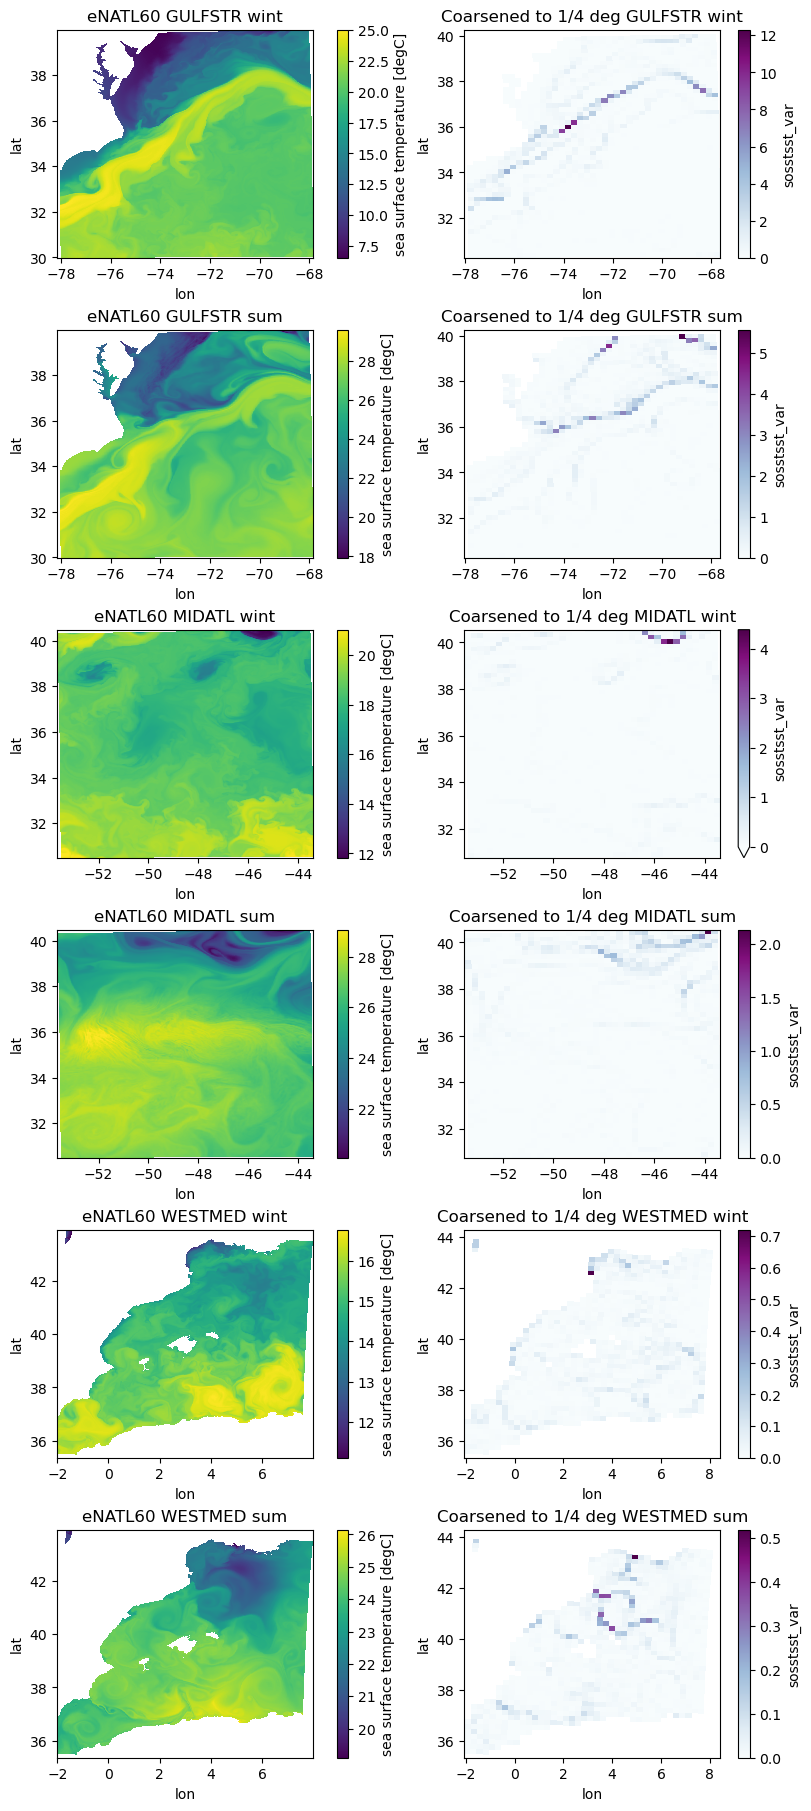

In [25]:
%%time
fig, ax = plt.subplots(ncols=2, nrows=len(data), figsize=(8,3.0*len(data)), constrained_layout=True)
for row, data_entity in enumerate(data) :
    data_entity['HR_new_coords'].sosstsst.isel(t=20).plot(ax=ax[row,0], x='lon', y='lat')
    data_entity['LR'].sosstsst_var.isel(t=20).plot(ax=ax[row,1], x='lon', y='lat',cmap='BuPu', vmin=0)
    ax[row,0].set(title='eNATL60 '+data_entity['label'])
    ax[row,1].set(title='Coarsened to 1/4 deg '+data_entity['label'])

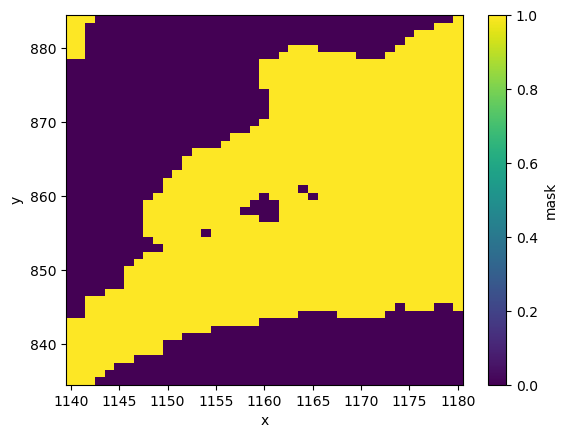

In [26]:
global_grid_LR['mask'].where((global_grid_LR.lon<8) & (global_grid_LR.lon>-2) & \
                             (global_grid_LR.lat>35) & (global_grid_LR.lat<44), drop=True).mask.plot()

In [27]:
data[0]['LR']['mask'].shape

(51, 41)

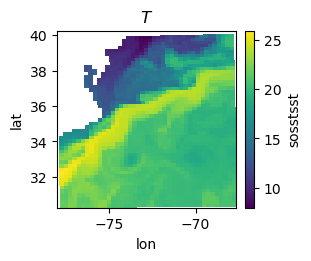

In [28]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3,2.5), constrained_layout=True)
data[0]['LR'].sosstsst.isel(t=2000).plot(ax=ax, x='lon', y='lat')
ax.set(title=r'$T$')
plt.show()

In [29]:
data[5]['LR']

<xarray.Dataset>
Dimensions:                (y_c: 47, y_r: 47, x_c: 40, x_r: 40, t: 2207)
Coordinates: (12/27)
  * y_c                    (y_c) int64 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47
  * y_r                    (y_r) float64 1.5 2.5 3.5 4.5 ... 44.5 45.5 46.5 47.5
  * x_c                    (x_c) int64 1 2 3 4 5 6 7 8 ... 34 35 36 37 38 39 40
  * x_r                    (x_r) float64 1.5 2.5 3.5 4.5 ... 37.5 38.5 39.5 40.5
    lat                    (y_c, x_c) float64 dask.array<chunksize=(47, 40), meta=np.ndarray>
    llat_cr                (y_c, x_r) float64 dask.array<chunksize=(47, 40), meta=np.ndarray>
    ...                     ...
    umask                  (y_c, x_r) int8 dask.array<chunksize=(47, 40), meta=np.ndarray>
    vmask                  (y_r, x_c) int8 dask.array<chunksize=(47, 40), meta=np.ndarray>
    fmask                  (y_r, x_r) int8 dask.array<chunksize=(47, 40), meta=np.ndarray>
    area                   (y_c, x_c) float64 dask.array<chunksize=(47, 40), meta=np.ndarray>
  * t                      (t) datetime64[ns] 2009-08-01T00:30:00 ... 2009-10...
    time_centered          (t) datetime64[ns] dask.array<chunksize=(150,), meta=np.ndarray>
Data variables: (12/38)
    sosstsst               (t, y_c, x_c) float32 dask.array<chunksize=(150, 47, 40), meta=np.ndarray>
    sosaline               (t, y_c, x_c) float32 dask.array<chunksize=(150, 47, 40), meta=np.ndarray>
    sigma0_true            (t, y_c, x_c) float64 dask.array<chunksize=(150, 47, 40), meta=np.ndarray>
    sigma0_true_sqr        (t, y_c, x_c) float64 dask.array<chunksize=(150, 47, 40), meta=np.ndarray>
    sosstsst_sqr           (t, y_c, x_c) float32 dask.array<chunksize=(150, 47, 40), meta=np.ndarray>
    sosaline_sqr           (t, y_c, x_c) float32 dask.array<chunksize=(150, 47, 40), meta=np.ndarray>
    ...                     ...
    diff_X_sosaline_var    (t, y_c, x_r) float32 dask.array<chunksize=(150, 47, 40), meta=np.ndarray>
    diff_Y_sosaline_var    (t, y_r, x_c) float32 dask.array<chunksize=(150, 47, 40), meta=np.ndarray>
    diff_sosaline_var_sqr  (t, y_c, x_c) float32 dask.array<chunksize=(150, 47, 40), meta=np.ndarray>
    predictor_T            (t, y_c, x_c) float64 dask.array<chunksize=(150, 47, 40), meta=np.ndarray>
    predictor_S            (t, y_c, x_c) float64 dask.array<chunksize=(150, 47, 40), meta=np.ndarray>
    predictor_TS           (t, y_c, x_c) float64 dask.array<chunksize=(150, 47, 40), meta=np.ndarray>